# Datasets & DataLoaders

維持（モジュール性、再利用性）管理（可読性）を高めるために、
- データ管理
- データ処理  

に分ける。

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## データセットの読み込み

In [ ]:
training_data = datasets.FashionMNIST(
    root='data',            # データセットの保存先を指定
    train=True,             # 指定？
    download=True,          # データが利用できない時、インターネットからダウンロードを行う。
    transform=ToTensor()    # データをテンソル化
)

100%|██████████| 26.4M/26.4M [00:08<00:00, 3.10MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 113kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.51MB/s]


In [7]:
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

### 見てみよう

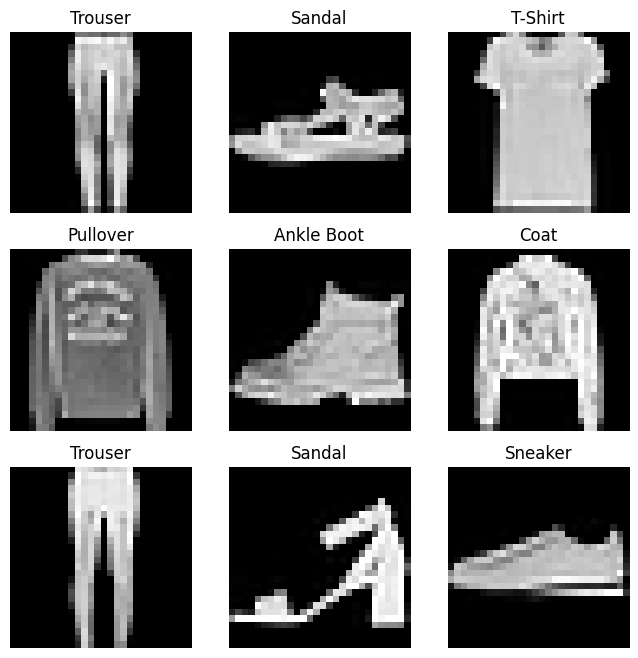

In [9]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Datasets

カスタムデータセットクラスを作成してみる。  

In [10]:
from pathlib import Path
import pandas as pd
from torchvision.io import decode_image

モデルが読み込みできるように、データセットの中身を教えてあげる。

In [11]:
class CustomImageDatasets(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = Path(self.img_dir) / self.img_labels.iloc[idx, 0]
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

**データの読み込み方を定義**  

```__init__```  
初期化  

```__len__```  
データセット内のサンプル数を返す

```__getitem__```  
指定されたインデックスにあるデータセットからサンプルを読み込んで返す。インデックスに基づいて、ディスク上の画像の位置を特定し、decode_imageを使用してそれをテンソルに変換、csvデータから対応するラベルを取得、それらに対して変換関数を呼び出し、テンソル画像と対応するラベルをタプルで返す。



```
ImageFolder
```

## DataLoaders

CustomImageDatasetsで作成した読み込み用の設計図をもとに、モデルに画像データを渡す。

以下は下記の3つの処理を行うAPIである。
- batch_size（mini batch化） 
モデルに1回あたりのデータを指定するセットで渡して、効率化
- shuffle  
リーク対策
- マルチプロセッシング (Multiprocessing)  
データ読み込みを高速化するために裏側でデータの読み込みを行っている。

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

中身を見てみよう

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


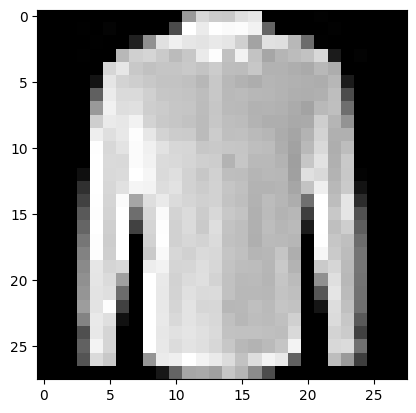

Label: 6


In [24]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")